# Exploring normalisation

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Import the PBMC 3k dataset again:

In [2]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

Add the easy QC metrics:

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

Normalize by read depth and scale to 10k or 1m counts:

In [4]:
expr_10k = sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000, copy=True)

In [5]:
expr_1M = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6, copy=True)

Why do the maxima look so similar for the 10k/1M objects? Why are they different from the raw, unnormalised object?

In [6]:
adata.X.max()

419.0

In [7]:
expr_10k.X.max()

1751.0548

In [8]:
expr_1M.X.max()

175105.48

Calculate distances...

In [9]:
sc.pp.neighbors(adata, use_rep="X")
sc.pp.neighbors(expr_10k, use_rep="X")
sc.pp.neighbors(expr_1M, use_rep="X")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

...and visualize:

In [10]:
sc.tl.umap(adata)
sc.tl.umap(expr_10k)
sc.tl.umap(expr_1M)

What do we observe from the raw and normalised datasets? Is there any evidence that read count affects the analysis? Does the overall structure stay the same or is it different?

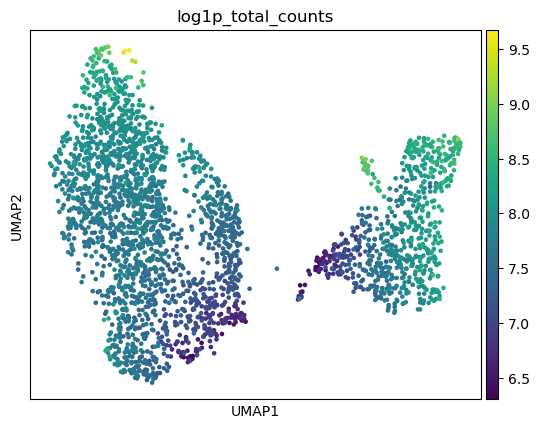

In [11]:
sc.pl.umap(adata, color="log1p_total_counts")

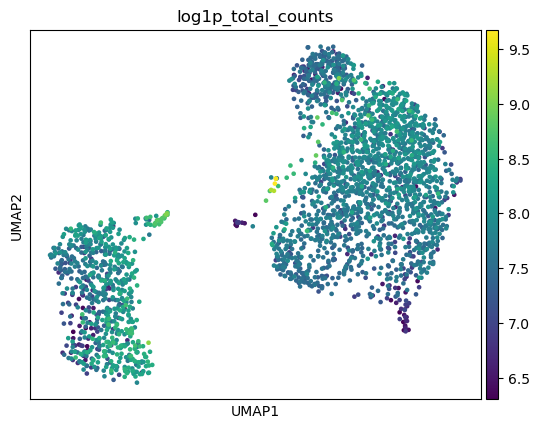

In [12]:
sc.pl.umap(expr_10k, color="log1p_total_counts")

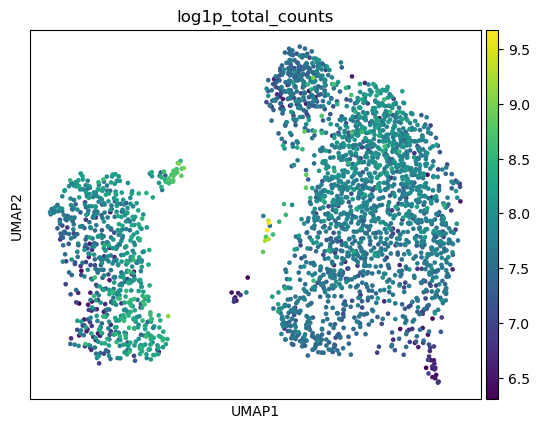

In [13]:
sc.pl.umap(expr_1M, color="log1p_total_counts")

Try the analytic Pearson residual normalisation. Does it work? What did we aim for? Did we achieve our aims?

In [14]:
no_zero = sc.pp.filter_genes(adata, min_counts=10, copy=True)

In [15]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(no_zero, inplace=False)
adata.obsm["pearson"] = analytic_pearson["X"]

In [16]:
sc.pp.neighbors(adata, use_rep="pearson")
sc.tl.umap(adata)

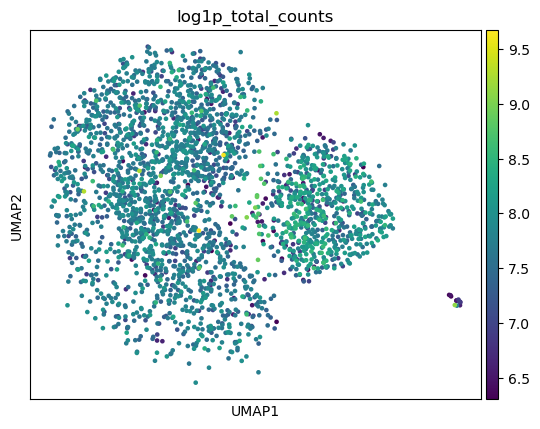

In [17]:
sc.pl.umap(adata, color="log1p_total_counts")

Try a home-cooked version of the z-score normalisation:

In [19]:
means = np.array(np.mean(adata.X, axis=0))[0]
vars = np.array(np.var(adata.X.toarray(), axis=0))

In [20]:
# fig, ax = plt.subplots()
# ax.scatter(means, vars)
# ax.set_xlim(0, 20)
# ax.set_ylim(0, 200)

In [21]:
std = np.std(adata.X.toarray(), axis=0)

In [22]:
def zscore(x, m, s):
    return (x - m) / s

In [23]:
dense = adata.X.toarray()

In [24]:
z = (dense - means) / std

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_22881/3234165681.py:1: RuntimeWarning: invalid value encountered in divide
  z = (dense - means) / std


In [25]:
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
adata.obsm["zscore"] = z

In [27]:
sc.pp.neighbors(adata, use_rep="zscore")
sc.tl.umap(adata)
sc.pl.umap(adata, color="log1p_total_counts")

ValueError: Input contains NaN.